<b>Universidad Galileo</b><br/>
<b>Maestría de Ciencia de Datos</b><br/>
<b>Statistical Learning I</b><br/>
<b>Jose Godoy</b><br/>
<b>Carnet 22000570</b><br/>
<b>4 de agosto 2022</b><br/>

# 1. Cargando librerías

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.manifold import TSNE
from sklearn import mixture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error, recall_score, f1_score

plt.rcParams["figure.figsize"] = (16, 12)

Deshabilitando warnings

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Cargamos la data

El dataset Fashion-MNIST cotiene 60,000 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Uniendo ambos datasets

In [4]:
images = np.concatenate((train_images, test_images), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# 3. Algoritmo PCA

In [5]:
import warnings
warnings.filterwarnings('ignore')

def PCA_(X, k):
    pca_X = X.copy()
    #Normalización
    pca_mean = np.mean(pca_X, axis=0)
    pca_std = np.std(pca_X, axis=0)
    pca_X_n = (pca_X - pca_mean)/pca_std
    #Matriz de covarianza
    pca_Sigma = np.cov(pca_X_n.T)
    #Eigen values
    (pca_values , pca_vectors) = np.linalg.eig(pca_Sigma)
    #Ordenamiento
    pca_index_values = np.argsort(-pca_values)
    pca_ordered_vectors = pca_vectors[:,pca_index_values]
    pca_reduced_vectors = pca_ordered_vectors[:,0:k]
    #Varianza preservada
    pca_values_k = pca_values[pca_index_values]
    pca_vp = np.sum(pca_values_k[0:k])/np.sum(pca_values)
    #Z
    Z = np.matmul(pca_reduced_vectors.T, pca_X_n.T)
    return (Z.T.real, pca_vp.real.round(2))

def PCA(X, k):
    i = X.shape[1]-1
    varianza_preservada = 0.0
    i_k = False
    while i >= k:
        (X, varianza_preservada) = PCA_(X, i)
        if( k == i):
            i_k = True
        i = i - 39
    if( i_k == False):
        (X, varianza_preservada) = PCA_(X, k)
    return (X, varianza_preservada)

# 4. Implementación

El data set original es un cubo 70k x 28 x 28, es decir, tiene 70k imagenes y cada una es una matriz de 28x28:

In [6]:
images.shape

(70000, 28, 28)

Lo siguiente aplana cada imagen, creando una matriz de 70k x 784, esto significa 70k registros con 784 features cada uno.

In [7]:
images_aplanada = images.reshape(images.shape[0], (images.shape[1]*images.shape[2]))
print(images_aplanada.shape)

(70000, 784)


## 4.1 PCA

In [24]:
(PCA_images, varianza_preservada) = PCA(images_aplanada, 2)
print("Nuevo tamaño:", PCA_images.shape)
print("Varianza preservada:", varianza_preservada)

Nuevo tamaño: (70000, 2)
Varianza preservada: 0.4


## 4.2 T-SNE

In [9]:
TSNE_images = TSNE(n_components=2).fit_transform(images_aplanada)
print("Nuevo tamaño:", TSNE_images.shape)

Nuevo tamaño: (70000, 2)


# 5. Clustering con GMM

Cantidad de etiquetas únicas:

In [10]:
cantidad_labels = len(np.unique(labels))

## 5.1 PCA

Text(0.5, 1.0, 'Real')

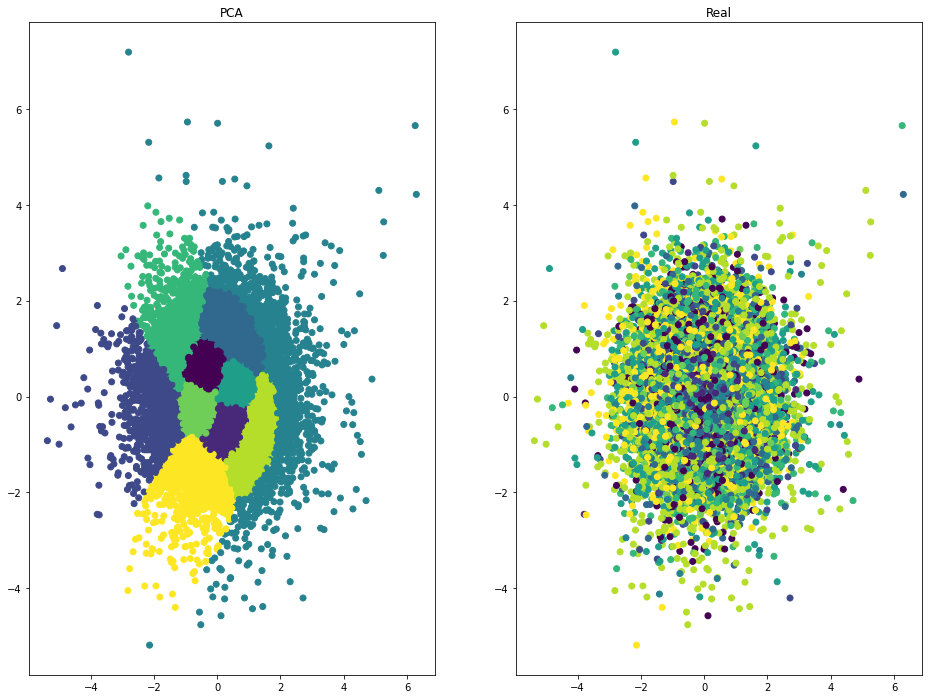

In [23]:
PCA_model = mixture.GaussianMixture(n_components= cantidad_labels ).fit(PCA_images.real)
PCA_model_label = PCA_model.predict(PCA_images.real)

f, axarr = plt.subplots(1,2)
axarr[0].scatter(PCA_images[:,0], PCA_images[:,1], alpha=1, c=PCA_model_label)
axarr[0].set_title('PCA')
axarr[1].scatter(PCA_images[:,0], PCA_images[:,1], alpha=1, c=labels)
axarr[1].set_title('Real')

## 5.2 T-SNE

Text(0.5, 1.0, 'Real')

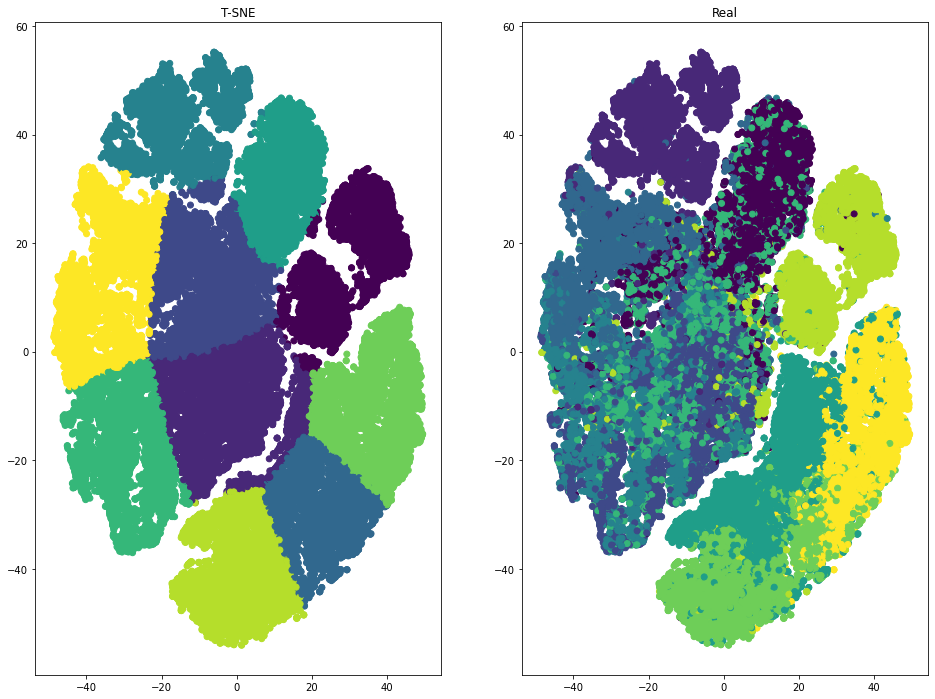

In [20]:
TSNE_model = mixture.GaussianMixture(n_components= cantidad_labels ).fit(TSNE_images)
TSNE_model_label = TSNE_model.predict(TSNE_images)

f, axarr = plt.subplots(1,2)
axarr[0].scatter(TSNE_images[:,0], TSNE_images[:,1], alpha=1, c=TSNE_model_label)
axarr[0].set_title('T-SNE')
axarr[1].scatter(TSNE_images[:,0], TSNE_images[:,1], alpha=1, c=labels)
axarr[1].set_title('Real')

# 6. Análisis de resultados

Función para generar métricas

In [21]:
def generar_metricas(nombre, E_yhat, E_y):
    resultados = pd.DataFrame([{
        'Algoritmo': nombre, 
        'MSE': mean_squared_error(E_y, E_yhat),
        'Accuracy Score': accuracy_score(E_y, E_yhat),
        'Recall Score': recall_score(E_y, E_yhat, average="macro"),
        'F1 Score': f1_score(E_y, E_yhat, average="macro")
    }])
    return resultados

In [22]:
PCA_metrics = generar_metricas("PCA", PCA_model_label, labels)
TSNE_metrics = generar_metricas("T-SNE", TSNE_model_label, labels)
pd.concat([PCA_metrics, TSNE_metrics]).set_index("Algoritmo")

,MSE,Accuracy Score,Recall Score,F1 Score
Algoritmo,,,,
PCA,19.678043,0.096043,0.096043,0.088381
T-SNE,17.604971,0.039357,0.039357,0.038287


# 7. Conclusión

La evidencia estadística indica que T-SNE es un mejor modelo de predicción aunque más tiempo de procesamiento para generar el modelo.